## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *

In [2]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(27)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), 
                          Resize((size, size)), ToTensor(), Normalize(mean=[0.4815], std=[0.2135])])

In [6]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)

In [7]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1083, 730, 2740, 4329, 3729, 4215, 4437, 296, 1622]


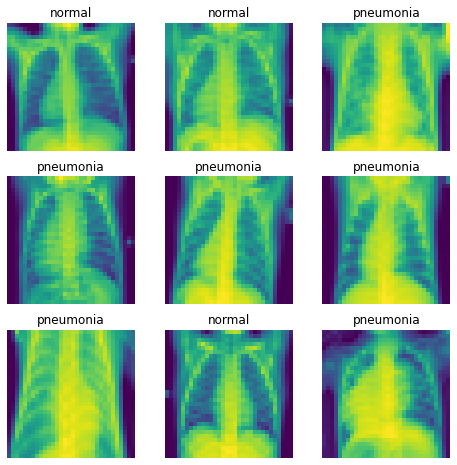

In [9]:
visualize_data(train_data)

[480, 394, 413, 384, 458, 360, 414, 124, 397]


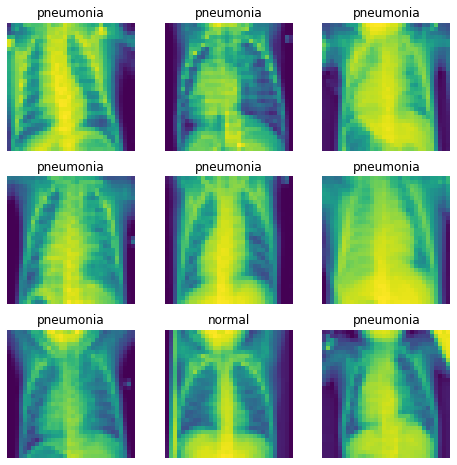

In [10]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [1, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [13]:
model = DeepLearn(kernels=kernels, hidden=hidden,
                  kernel_size=kernel_size, window=window,
                  hidden_linear=hidden_linear).to(device)
print(model)

DeepLearn(
  (conv_combined): Sequential(
    (0): DeepLearnConv(
      (conv): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepLearnConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepLearnConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepLearnLinear(
      (linear): Linear(in_features=10816, out_features=512, bias=True)
  

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr=0.001)

In [16]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 4)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/4, Batch number: 0, Cumulated accuracy: 0.484375
Epoch 1/4, Batch number: 5, Cumulated accuracy: 0.7552083333333334
Epoch 1/4, Batch number: 10, Cumulated accuracy: 0.7876420454545454
Epoch 1/4, Batch number: 15, Cumulated accuracy: 0.80859375
Epoch 1/4, Batch number: 20, Cumulated accuracy: 0.8240327380952381
Epoch 1/4, Batch number: 25, Cumulated accuracy: 0.8362379807692307
Epoch 1/4, Batch number: 30, Cumulated accuracy: 0.8442540322580645
Epoch 1/4, Batch number: 35, Cumulated accuracy: 0.8530815972222222
--- Epoch 1/4: Train loss: 0.3587, Train accuracy: 0.8534
--- Epoch 1/4: Val loss: 0.2907, Val accuracy: 0.8838
Epoch 2/4, Batch number: 0, Cumulated accuracy: 0.8671875
Epoch 2/4, Batch number: 5, Cumulated accuracy: 0.875
Epoch 2/4, Batch number: 10, Cumulated accuracy: 0.8913352272727273
Epoch 2/4, Batch number: 15, Cumulated accuracy: 0.890625
Epoch 2/4, Batch number: 20, Cumulated accuracy: 0.8936011904761905
Epoch 2/4, Batch number: 25, Cumulated accuracy: 0.8900240

## Testing Model & Performance Curves

In [17]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.3337, Test accuracy: 0.8547


Precision: 0.8701298701298701
Recall: 0.9414519906323185
F1 score: 0.9043869516310462


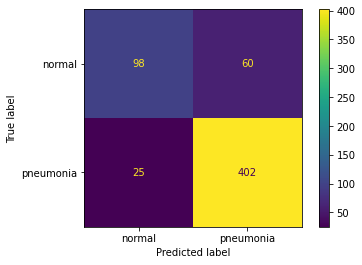

In [18]:
show_metrics(true_labels, model_preds)

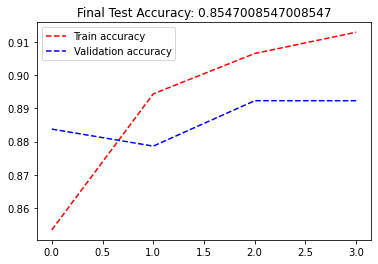

In [19]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

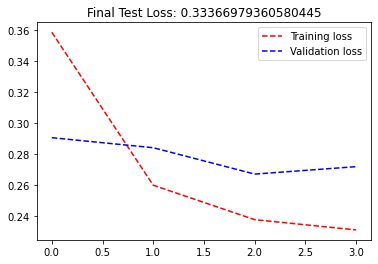

In [20]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [21]:
test_loader2 = produce_loader(test_data, 1)

In [22]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.8777292576419214
Recall: 0.9414519906323185
F1 score: 0.9084745762711866


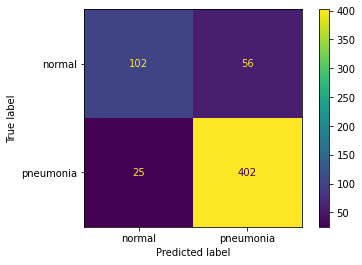

In [23]:
show_metrics(true_labels2, model_preds2)

[299, 490, 386, 485, 443, 365, 181, 365, 179, 382, 167, 387, 176, 146, 359, 394, 97, 175, 181, 78, 428, 107, 385, 123, 295]


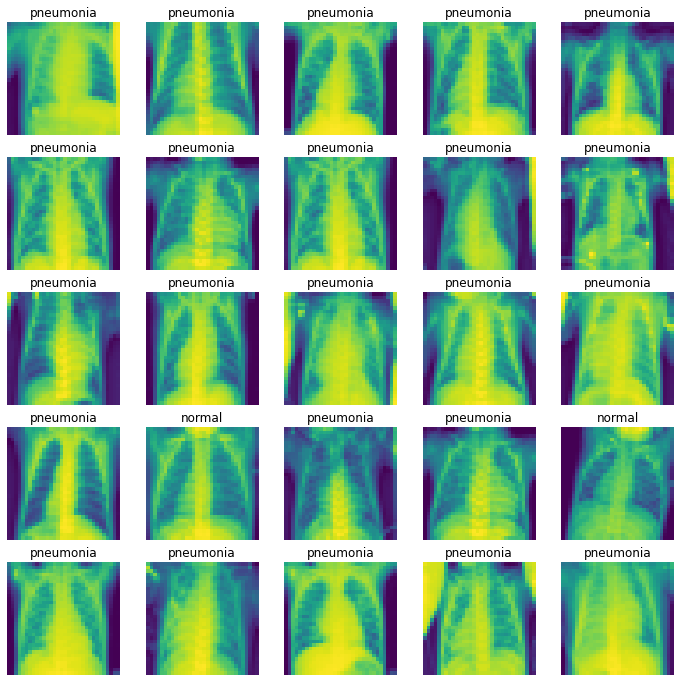

In [24]:
visualize_data(correct_list, (12,12), 5)

[19, 47, 34, 65, 64, 26, 53, 50, 34, 25, 42, 29, 40, 79, 0, 20, 48, 43, 25, 1, 44, 72, 39, 34, 30]


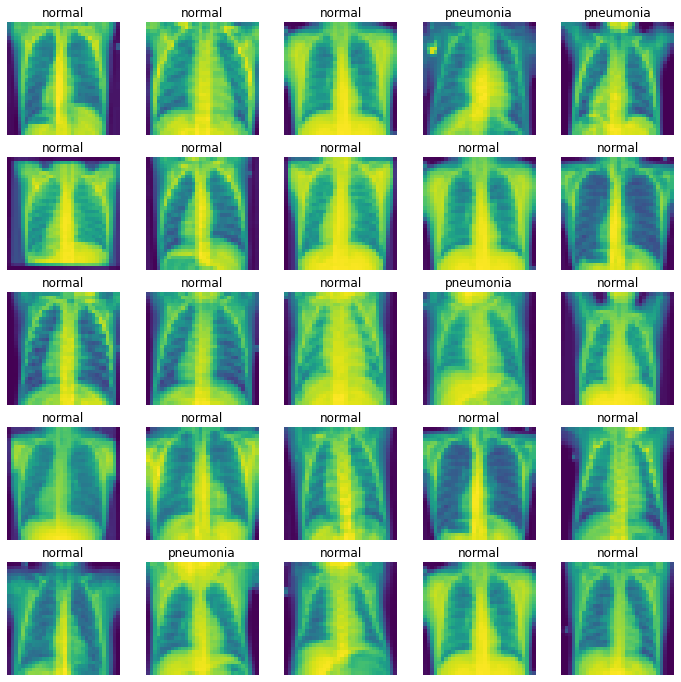

In [25]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepLearn_4epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])